In [1]:
import uproot
from glob import glob
import json 
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
pi0_dir = '/clusterfs/ml4hep/mpettee/ml4pions/data/user.angerami.mc16_13TeV.900246.PG_singlepi0_logE0p2to2000.e8312_e7400_s3170_r12383.v01-45-gaa27bcb_OutputStream/'
pion_dir = '/clusterfs/ml4hep/mpettee/ml4pions/data/user.angerami.mc16_13TeV.900247.PG_singlepion_logE0p2to2000.e8312_e7400_s3170_r12383.v01-45-gaa27bcb_OutputStream/'
pi0_files = sorted(glob(pi0_dir+"*.root"))
pion_files = sorted(glob(pion_dir+"*.root"))

Check out one file as a test...

In [107]:
a = uproot.open(pion_files[100])["EventTree"].arrays(library = "np")
a.keys()

dict_keys(['runNumber', 'eventNumber', 'lumiBlock', 'coreFlags', 'mcEventNumber', 'mcChannelNumber', 'mcEventWeight', 'nTruthPart', 'G4PreCalo_n_EM', 'G4PreCalo_E_EM', 'G4PreCalo_n_Had', 'G4PreCalo_E_Had', 'truthVertexX', 'truthVertexY', 'truthVertexZ', 'truthPartPdgId', 'truthPartStatus', 'truthPartBarcode', 'truthPartPt', 'truthPartE', 'truthPartMass', 'truthPartEta', 'truthPartPhi', 'nTrack', 'trackPt', 'trackP', 'trackMass', 'trackEta', 'trackPhi', 'trackNumberOfPixelHits', 'trackNumberOfSCTHits', 'trackNumberOfPixelDeadSensors', 'trackNumberOfSCTDeadSensors', 'trackNumberOfPixelSharedHits', 'trackNumberOfSCTSharedHits', 'trackNumberOfPixelHoles', 'trackNumberOfSCTHoles', 'trackNumberOfInnermostPixelLayerHits', 'trackNumberOfNextToInnermostPixelLayerHits', 'trackExpectInnermostPixelLayerHit', 'trackExpectNextToInnermostPixelLayerHit', 'trackNumberOfTRTHits', 'trackNumberOfTRTOutliers', 'trackChiSquared', 'trackNumberDOF', 'trackD0', 'trackZ0', 'trackEta_PreSamplerB', 'trackPhi_PreS

In [ ]:
# [var for var in a.keys() if "Eta" in var]

Now apply all the cuts...

In [118]:
def apply_cuts_new(arrays):
    df = pd.DataFrame(arrays)
    
    ### Single-track, multi-cluster 
    df['num_tracks'] = [len(x) for x in df.trackEta]
    df = df[(df.nCluster>0) & (df.num_tracks==1)]
    df.reset_index(inplace=True, drop=True)
    
    deltaEta = (df['cluster_Eta'] - df['trackEta'])**2
    df['deltaEta_squared'] = deltaEta
    delta_cosPhi = list(map(np.cos, df['cluster_Phi'] - df['trackPhi']))
    deltaPhi = [x**2 for x in map(np.arccos, delta_cosPhi)]
    df['deltaPhi_squared'] = deltaPhi
    deltaR = list(map(np.sqrt, deltaEta + deltaPhi))
    deltaR_pass = [sum(x<1.2) for x in deltaR]   # cut 1.2
    
    df["deltaR"] = deltaR
    df["dR_pass"] = deltaR_pass
#     df["event_number"] = df.index

    df = df.loc[deltaR_pass]
    return df 

In [151]:
import math 
def delta_phi(phi1, phi2):
    return (phi1 - phi2 + math.pi) % (2*math.pi) - math.pi

def apply_cuts(arrays):
    df = pd.DataFrame(arrays)

    ### Single-track, multi-cluster 
    df['num_tracks'] = [len(x) for x in df.trackEta] # more robust than nTrack, weirdly
    df = df[(df.nCluster==1) & (df.num_tracks==1)]
    df.reset_index(inplace=True, drop=True)
    
    dR = []
    dR_pass = []
    deltaR_list = []
    for row in df.index:
        try:
            deltaR = np.sqrt((df['cluster_Eta'][row].astype('float') - df['trackEta'][row].astype('float'))**2 + 
                               delta_phi(df['cluster_Phi'][row].astype('float'), df['trackPhi'][row].astype('float'))**2)
        except:
            deltaR = np.array(999)
        deltaR_list.append(deltaR)
        dR_pass.append(deltaR < 1.2)
    df["deltaR"] = deltaR_list
    df["dR_pass"] = dR_pass
#     df["event_number"] = df.index
    indices_pass = [] 
    for row in df.index: # kill all events with no clusters passing the delta R cut; deal with individual clusters at the training stage
        if len(df['trackPt'][row]) > 1:
            continue
        elif df.dR_pass[row].sum() > 0:
            indices_pass.append(row)
    df = df.iloc[indices_pass]
    df = df[(df.trackPt < 10**5)] # Track pT cut 
    return df, indices_pass

### Test:

In [152]:
# use a pared-down list of variables 
variables = ['cluster_cell_E', 'cluster_cell_ID',
             'trackPt','trackD0','trackZ0',
             'trackEta_EMB2','trackPhi_EMB2',
             'trackEta_EME2','trackPhi_EME2',
             'trackEta','trackPhi',
             'nCluster','nTrack','truthPartE', 'truthPartPt',
             'cluster_ENG_CALIB_TOT','cluster_E','cluster_Eta','cluster_Phi',
             'cluster_EM_PROBABILITY','cluster_E_LCCalib','cluster_HAD_WEIGHT']

In [120]:
df_mariel, indices_pass = apply_cuts(a)

In [121]:
len(df_mariel)

10320

In [122]:
df_piyush = apply_cuts_new(a)

In [123]:
len(df_piyush)

10320

In [124]:
df_mariel.deltaR

0                                    [0.04897740267047874]
1        [0.027312371394339667, 0.03360527223263652, 0....
2                                    [0.04369151591490291]
3        [0.24845308396660284, 0.19006737881856542, 0.2...
4                                   [0.026443983222161387]
                               ...                        
10315                               [0.026170231622103766]
10316                                [0.05101393722708002]
10317         [0.012251382961085461, 0.018481895095784708]
10318                               [0.003708192846622447]
10319    [0.028824246837587355, 0.3358071331092595, 0.0...
Name: deltaR, Length: 10320, dtype: object

In [129]:
df_piyush.dR

0                                            [0.048977703]
1                    [0.02731153, 0.033605475, 0.12673567]
2                                             [0.04369104]
3        [0.24845317, 0.19006744, 0.21971776, 0.2516792...
4                                            [0.026443195]
                               ...                        
10315                                        [0.026169779]
10316                                        [0.051014107]
10317                            [0.01224952, 0.018481797]
10318                                       [0.0037065262]
10319                [0.028824987, 0.33580714, 0.02140639]
Name: dR, Length: 10320, dtype: object

In [144]:
df_mariel.iloc[indices_pass].eventNumber.value_counts()

1553183    1
1565172    1
1566817    1
1565427    1
1566203    1
          ..
1559140    1
1559596    1
1560038    1
1560725    1
1571137    1
Name: eventNumber, Length: 10222, dtype: int64

In [131]:
df_mariel.dR_pass

0                                [True]
1                    [True, True, True]
2                                [True]
3        [True, True, True, True, True]
4                                [True]
                      ...              
10315                            [True]
10316                            [True]
10317                      [True, True]
10318                            [True]
10319                [True, True, True]
Name: dR_pass, Length: 10320, dtype: object

In [140]:
np.array(df_piyush.dR_pass)

array([1, 3, 1, ..., 2, 1, 3])

In [142]:
df_piyush.loc[np.array(df_piyush.dR_pass)].eventNumber.value_counts()

1554967    3676
1553471    2656
1554642    1579
1554562     840
1553078     488
1554569     323
1553270     211
1554838     146
1553183      98
1553052      97
1554561      57
1554889      56
1554823      28
1554426      21
1553360      13
1554814       8
1554600       5
1553916       5
1553084       4
1553436       3
1554449       2
1553877       1
1553065       1
1554328       1
1554222       1
Name: eventNumber, dtype: int64

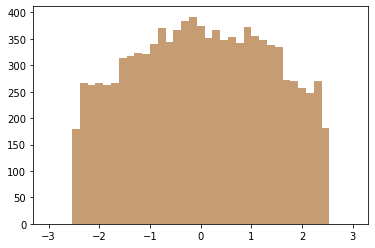

In [70]:
plt.hist(df_new.trackEta.explode(), alpha=0.5, bins=np.linspace(-3,3,40));
plt.hist(df.trackEta.explode(), alpha=0.5, bins=np.linspace(-3,3,40));

In [5]:
# for file in tqdm(pi0_files):
#     prefix = file.split("/")[:-2]
#     number = file.split("000")[-1][:-5]
#     folder = os.path.join("/".join(prefix), "onetrack_multicluster", "pi0_files")
#     os.makedirs(folder, exist_ok=True)
#     npy_filename = os.path.join(folder, str(number)+".npy")
#     a = uproot.open(file)["EventTree"].arrays(variables, library = "np")
#     df = apply_cuts(a)
#     a_cuts = df.to_dict('list')
#     np.save(npy_filename, a_cuts) 

In [153]:
for file in tqdm(pion_files[:100]):
    prefix = file.split("/")[:-2]
    number = file.split("000")[-1][:-5]
    folder = os.path.join("/".join(prefix), "onetrack_multicluster", "pion_files_stsc")
    os.makedirs(folder, exist_ok=True)
    npy_filename = os.path.join(folder, str(number)+".npy")
    a = uproot.open(file)["EventTree"].arrays(variables, library = "np")
    df = apply_cuts_new(a)
    a_cuts = df.to_dict('list')
    np.save(npy_filename, a_cuts) 

  0%|          | 0/100 [00:00<?, ?it/s]/clusterfs/ml4hep/mpettee/miniconda3/envs/nbdev/lib/python3.9/site-packages/pandas/core/computation/expressions.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return op(a, b)
 64%|██████▍   | 64/100 [04:14<02:22,  3.97s/it]


KeyboardInterrupt: 

### Testing

In [8]:
df = apply_cuts(a)

In [ ]:
plt.hist(df.deltaR.explode(), bins=25);

In [ ]:
### Start the dataframe of inputs 
max_n_clusters = pd.DataFrame(df.cluster_E.to_list()).shape[1]
df2 = pd.DataFrame(pd.DataFrame(df.cluster_E.to_list(), columns=["cluster_e_"+str(x) for x in np.arange(max_n_clusters)])) # just take the leading cluster E 

### Add track pT & truth particle E 
track_pt = np.array(df.trackPt.explode())
truth_particle_e = np.array(df.truthPartE.explode())
track_eta = np.array(df.trackEta.explode())
track_phi = np.array(df.trackPhi.explode())
track_z0 = np.array(df.trackZ0.explode())

df2["track_pt"] = track_pt
df2["track_eta"] = track_eta
df2["track_phi"] = track_phi
df2["track_z0"] = track_z0
df2["truth_particle_e"] = truth_particle_e

### Drop NaNs 
df2.replace([np.inf, -np.inf], np.nan, inplace=True)
# df2 = df2.dropna()
df2 = df2.fillna(0)

### Cluster_E > 0.5
df2 = df2[df2.cluster_e_0 > 0.5]

### Lose outliers in track pT 
df2 = df2[df2.track_pt < 5000]

### Cast as float
df2 = df2.astype('float32')

### Add the log of all variables
for var in df2.keys():
    if var in ["track_eta", "track_phi", "track_z0"]:
        continue
    else:
        df2['log10_'+var] = np.log10(df2[var])
    
### Do this again? 
df2.replace([np.inf, -np.inf], np.nan, inplace=True)
df2 = df2.fillna(0)

In [ ]:
import seaborn as sns
### Inspect variables 
sns.set(font_scale = 2)
# corr_vars = ['truth_particle_e', 'cluster_e_0', 'track_pt', 'track_eta', 'track_phi', 'track_z0']
corr_vars = ['truth_particle_e', 'cluster_e_0', 'track_pt', 'track_z0']
g = sns.pairplot(df2[corr_vars], diag_kind='kde')
g.fig.set_figheight(12)
g.fig.set_figwidth(12)

In [ ]:
sc = StandardScaler()
train_x = sc.fit_transform(train_x)
test_x = sc.transform(test_x)

In [ ]:
all_drs = []
dfs = []
for file in tqdm(pion_files[:10]):
    prefix = file.split("/")[:-2]
    number = file.split("000")[-1][:-5]
    folder = os.path.join("/".join(prefix), "onetrack_multicluster", "pion_files")
    os.makedirs(folder, exist_ok=True)
    npy_filename = os.path.join(folder, str(number)+".npy")
    a = uproot.open(file)["EventTree"].arrays(variables, library = "np")
    df = apply_cuts(a)
    list = df.deltaR.to_numpy().flatten()
    drs = np.concatenate(list, axis=0)
    all_drs.append(drs)
    dfs.append(df)
    
import matplotlib.pyplot as plt
all_drs = np.concatenate(all_drs, axis=0)

plt.figure(dpi=200)
plt.hist(all_drs, bins=np.linspace(0.5,1.5,30));
plt.xlabel(r"$\Delta R$(cluster,track)")

plt.figure(dpi=200)
plt.hist(all_drs, bins=np.linspace(0.5,1.5,30));
plt.yscale("log")
plt.xlabel(r"$\Delta R$(cluster,track)")

In [ ]:
df = pd.concat([df for df in dfs])

In [ ]:
plt.figure(dpi=150)
plt.hist(np.concatenate(df.trackPt.to_numpy().flatten(), axis=0), bins=10);
plt.xlabel(r"Track $p_T$")
plt.yscale("log")

### Scaling

In [ ]:
cluster_cell_e = []
cluster_e = []
cluster_eta = []
cluster_phi = []
track_pt = []
track_z0 = []
track_eta = []
track_phi = []
truth_part_e = []

n_files = 10

for file in tqdm(pion_files[:n_files]):
    prefix = file.split("/")[:-2]
    number = file.split("000")[-1][:-5]
    a = uproot.open(file)["EventTree"].arrays(variables, library = "np")
    df = apply_cuts(a)
    track_pt.append(df.trackPt.explode())
    track_z0.append(df.trackZ0)
    track_eta.append(df.trackEta)
    track_phi.append(df.trackPhi)
    truth_part_e.append(df.truthPartE.explode())
    for i in range(len(df)): 
        for cluster in range(df.nCluster.iloc[i]):
            cluster_cell_e.append(np.array(np.log10(df.cluster_cell_E.iloc[i][cluster])))
            cluster_e.append(np.array(np.log10(df.cluster_E.iloc[i][cluster])))
            cluster_eta.append(np.array(df.cluster_Eta.iloc[i][cluster]))
            cluster_phi.append(np.array(df.cluster_Phi.iloc[i][cluster]))

print("Track pT | mean: {} | std: {}".format(np.mean([np.log10(x) for x in np.concatenate(track_pt)]), np.std([np.log10(x) for x in np.concatenate(track_pt)])))
print("Track z0 | mean: {} | std: {}".format(np.mean(np.concatenate(track_z0)), np.std(np.concatenate(track_z0))))
print("Track eta | mean: {} | std: {}".format(np.mean(np.concatenate(track_eta)), np.std(np.concatenate(track_eta))))
print("Track phi | mean: {} | std: {}".format(np.mean(np.concatenate(track_phi)), np.std(np.concatenate(track_phi))))

print("Truth particle E | mean: {} | std: {}".format(np.mean([np.log10(x) for x in np.concatenate(truth_part_e)]), np.std([np.log10(x) for x in np.concatenate(truth_part_e)])))

print("Cluster cell e")
print(np.mean(np.concatenate(cluster_cell_e)))
print(np.std(np.concatenate(cluster_cell_e)))
        
print("Cluster e")
print(np.mean(cluster_e))
print(np.std(cluster_e))

print("Cluster eta")
print(np.mean(cluster_eta))
print(np.std(cluster_eta))

print("Cluster phi")
print(np.mean(cluster_phi))
print(np.std(cluster_phi))

In [ ]:
scales = {
    'track_pt_mean': 1.633278727,
    'track_pt_std': 0.8481947183,
    'track_z0_mean': 0.08022017,
    'track_z0_std': 42.53320004,    
    'track_eta_mean': -0.00563187,
    'track_eta_std': 1.35242735,    
    'track_phi_mean': 0.00206431,
    'track_phi_std': 1.81240248,   
    'truth_part_e_mean': 1.92469358, 
    'truth_part_e_std': 0.8289864, 
    'cluster_cell_e_mean': -1.0121697,
    'cluster_cell_e_std': 0.818357, 
    'cluster_e_mean': 0.89923394,
    'cluster_e_std': 1.0585934,
    'cluster_eta_mean': 0.016195267,
    'cluster_eta_std': 1.3400925,
    'cluster_phi_mean': 0.0050816955,
    'cluster_phi_std': 1.8100655,
         }

In [ ]:
cell_geo_file = "/clusterfs/ml4hep/mpettee/ml4pions/data/cell_geo.root"
df = uproot.open(cell_geo_file)['CellGeo'].arrays(library='pd')
df.reset_index(inplace=True)
vars = ['cell_geo_sampling', 'cell_geo_eta', 'cell_geo_phi', 'cell_geo_rPerp', 'cell_geo_deta', 'cell_geo_dphi']
for var in vars: 
    print(var)
    print(np.mean(df[var]))
    print(np.std(df[var]))

In [ ]:
scales.update({
    'cell_geo_sampling_mean': 3.8827391420197177,
    'cell_geo_sampling_std': 3.9588233603576204,
    'cell_geo_eta_mean': 0.0005979097,
    'cell_geo_eta_std': 1.4709069,
    'cell_geo_phi_mean': -2.8938382e-05,
    'cell_geo_phi_std': 1.813651,
    'cell_geo_rPerp_mean': 1478.9285,
    'cell_geo_rPerp_std': 434.60815,
    'cell_geo_deta_mean': 0.026611786,
    'cell_geo_deta_std': 0.03396141,
    'cell_geo_dphi_mean': 0.068693615,
    'cell_geo_dphi_std': 0.038586758,  
})

In [ ]:
scales

In [ ]:
# Node features: 
# {
# np.log10(cluster_cell_E), 
# cell_geo_sampling, 
# cell_geo_eta, 
# cell_geo_phi, 
# cell_geo_rPerp, 
# cell_geo_deta, 
# cell_geo_dphi
#}

In [ ]:
node_means = [
    scales["cluster_cell_e_mean"], 
    scales["cell_geo_sampling_mean"],
    scales["cell_geo_eta_mean"],
    scales["cell_geo_phi_mean"],
    scales["cell_geo_rPerp_mean"],
    scales["cell_geo_deta_mean"],
    scales["cell_geo_dphi_mean"],
] 

node_stds = [
    scales["cluster_cell_e_std"], 
    scales["cell_geo_sampling_std"],
    scales["cell_geo_eta_std"],
    scales["cell_geo_phi_std"],
    scales["cell_geo_rPerp_std"],
    scales["cell_geo_deta_std"],
    scales["cell_geo_dphi_std"],
] 

In [ ]:
node_means

In [ ]:
node_stds